# EBP Notebook

During my time at the Fed, I used to work with a model that modeled sentiment in the credit market.  Like financial asset prices generally, this decomposed credit spread measure is a forward looking metric and contains information on the real economy.  As such, this measure is a significat factor in predicting the probability of being in a recession over the next 12 months.  Given these attributes and outputs of the model, this statistic was closely monitored by policymakers and market particiapants and is regularly updated by the Fed each month.  In this post, I briefly go over the construction of this metric (EBP), and visualize the recent movements and the implications.  




Both the GZ credit spread and the EBP have increased significantly prior to or during most of the cyclical downturns since the start of the sample. 
Additionally, since March this year, the EBP climbed to levels last seen in the early summer of 2008, just a few months before the nadir of the financial crisis; however, this pronounced deterioration in credit market sentiment has receeded, but remains slightly elevated since pre-pandemic levels.


In terms of what this Python code does, I pull data updated in a [FEDS Note](https://www.federalreserve.gov/econresdata/notes/feds-notes/2016/updating-the-recession-risk-and-the-excess-bond-premium-20161006.html) and access recession dates from the FRED API.  Additionally, I create some pretty figures which include two y-axes, and include shading during recession periods.  

## Introduction

[Gilchrist and Zakrajšek (2012)](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.102.4.1692) (GZ), introduce a  corporate bond credit spread by using data from secondary market prices of senior unsecured bonds.  Yield spreads for each underlying corporate security are derived from a synthetic risk-free security that mimics the cash flows of that bond, bypassing any duration mismatch problems.  This gives the monthly GZ spread the average across firms:
$$S_t^{GZ} = \frac{1}{N_t}\sum_i \sum_k S_{i,t}[k]$$
where $N$ denotes the number of bonds in month $t$ and $S_{i,t}[k]$ is the spread of firm $i$'s bond k in the same month. 


Individual credit spreads are estimated using linear regression to remove a measure of expected default risk (Merton's distance to default).  By assuming  the log of the credit spread on bond $k$ to be linearly related to a firm-specific indicator of default ($DFT$) and a set of bond characteristics $(\textbf{Z})$ like the duration, amount outstanding, the coupon rate, age, and if the bond is callable:
$$\ln S_{i,t}[k] = \beta DFT_{i,t} + \gamma' \textbf{Z}_{i,t}[k] + \varepsilon_{i,t}[k]$$

Assuming normally distributed pricing errors ($\varepsilon$), the predicted level of the spread for bond $k$ of firm $i$ at time $t$ is
$$\hat{S}_{i,t}[k] = \exp \left[ \hat{\beta}DFT_{i,t} + \hat{\gamma}' Z_{i,t}[k] + \frac{\hat{\sigma}^2}{2} \right]$$
where $\hat{\beta}$ and $\hat{\gamma}$ are the point estimates of the parameters and $\sigma^2$ being the estimated conditional variance of the pricing errors. This is the part of the credit spread that can be attributed to a firm's specific bond $i$ expected default risk.  


Like above, the part of the credit spread that is directly attributable to expected default risk is given by the average of predicted spreads in month $t$ is:
$$\hat{S}^{GZ}_{i,t}[k] = \frac{1}{N} \sum_i \sum_k \hat{S}_{i,t}[k]$$


Lastly, the rich component of the credit spread called EBP is the differenced measures of credit spreads:

$$EBP_t = S_t^{GZ} - \hat{S}_t^{GZ}$$



This procedure decomposes the calculated GZ credit spread into two parts: $S^{GZ}_t$, a component that captures default risk of individual firms; and $EBP_t$, a residual component that can be thought of as capturing investor attitudes toward corporate credit risk or credit market sentiment. 
These reference argue that the EBP tries to capture the variation in the average price of bearing U.S. corporate credit risk above and beyond the compensation that investors in the corporate bond market require for expected defaults. As documented by GZ, the EBP is significantly more informative--in both economic and statistical terms--about future economic activity than a component of the GZ credit spread that can be directly attributed to expected defaults.  Additionally, the EBP measures offers additional information that is not captured by the term spread, another spread used to predict future economic activity.  







### Load the EBP data and NBER recession dates from FRED API

In [6]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fredapi import Fred
fred = Fred(api_key='3d98a695a7a09b42b521a09547990f22') # own API key.  Very easy to get your own


# load in EBP data
ebp_link = "https://www.federalreserve.gov/econresdata/notes/feds-notes/2016/files/ebp_csv.csv"
ebp_data = pd.read_csv(ebp_link, index_col='date',parse_dates=True )



# load Fred data
recession_dates = pd.DataFrame(fred.get_series('USREC'))
recession_dates=recession_dates.rename(columns={recession_dates.columns[0]: "recession_dummy"})



# inner join on  the date index
ebp_data = ebp_data.join(recession_dates, how='inner')

# convert from float to integer
ebp_data["recession_dummy"] = ebp_data["recession_dummy"].astype(int)

last_date=ebp_data.index[-1]

Note = "Note: Shaded areas denote NBER-dated recessions. Data as of %s." %(last_date.strftime('%b. %Y'))

print(Note) 
ebp_data.info()
ebp_data.tail()
ebp_data.describe()

Note: Shaded areas denote NBER-dated recessions. Data as of Jul. 2020.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 571 entries, 1973-01-01 to 2020-07-01
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gz_spread        571 non-null    float64
 1   ebp              571 non-null    float64
 2   est_prob         571 non-null    float64
 3   recession_dummy  571 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 22.3 KB


,gz_spread,ebp,est_prob,recession_dummy
count,571.000000,571.000000,571.000000,571.000000
mean,1.804665,0.060766,0.249950,0.134851
std,0.945770,0.555843,0.193779,0.341864
min,0.548800,-1.113400,0.014413,0.000000
25%,1.222300,-0.292400,0.119239,0.000000
50%,1.608300,-0.069700,0.182572,0.000000
75%,2.106300,0.261400,0.308726,0.000000
max,7.984000,3.467300,0.999701,1.000000


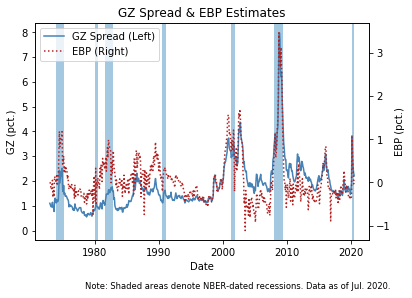

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

lns1 = ax.plot('gz_spread', data=ebp_data,  color="steelblue", label = 'GZ Spread (Left)')
ax2 = ax.twinx()
lns2 = ax2.plot('ebp',data=ebp_data, color="firebrick", linestyle='dotted',  label = 'EBP (Right)')

# better legend
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.fill_between(ebp_data.index, 0,1, where=ebp_data['recession_dummy'], alpha=0.4, transform=ax.get_xaxis_transform())

# format legend
ax.set_xlabel("Date")
ax.set_ylabel(r"GZ (pct.)")
ax2.set_ylabel(r"EBP (pct.)")
plt.title('GZ Spread & EBP Estimates')
plt.figtext(.95, -0.05, Note, ha='right', va='bottom',
           fontsize='small')
plt.show()

## Predicting Recessions

To isolate the role of credit market sentiment in U.S. business cycle fluctuations, the Fed kindly reports the in-sample fitted probability of a recession over the subsequent 12 months using the specification:
$$P(NBER_{t,t+12}=1) = \Phi(\alpha + \beta EBP_t)$$
This is reflected in Table 3 of the [FEDS Note](https://www.federalreserve.gov/econresdata/notes/feds-notes/2016/recession-risk-and-the-excess-bond-premium-20160408.html#f2). As shown by the solid line, this probability has moved up significantly since the start of the year, peaking around 0.70 in March, coinciding with an increase in financial market volatility, and a deterioration in investor sentiment in the United States and abroad due to the Coronovirus.  These concerns that triggered deteroiration of investor sentiment apparently abated over the spring and summer, and the corresponding EBP-implied odds of the economy falling into a recession over the subsequent 12 months moved down to roughly 20%.


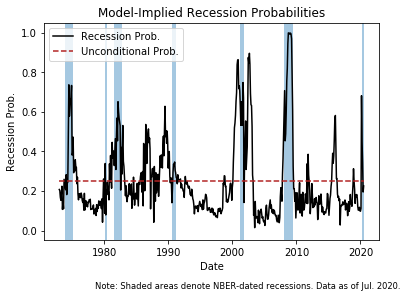

In [5]:
# plot recession probability
fig, ax1 = plt.subplots()
ebp_data['uncon_mean'] = ebp_data['est_prob'].mean()


ax1.plot('est_prob', data=ebp_data, color='black', label="Recession Prob.")
ax1.plot('uncon_mean', data=ebp_data, color='firebrick', linestyle='dashed', label="Unconditional Prob.")
ax1.fill_between(ebp_data.index, 0,1, where=ebp_data['recession_dummy'], alpha=0.4, transform=ax1.get_xaxis_transform())
ax1.set_xlabel('Date')
ax1.set_ylabel('Recession Prob.', color='black')


ax1.legend()
plt.title('Model-Implied Recession Probabilities')
plt.figtext(.95, -0.05, Note, ha='right', va='bottom',
           fontsize='small')
plt.show()
plt.close('all')


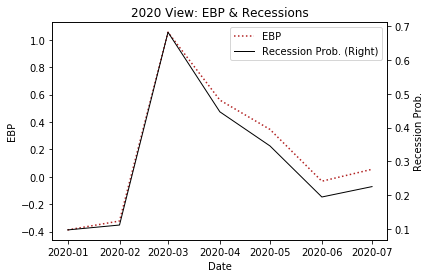

In [122]:
# Subset data for a window since pandemic
sub_data=ebp_data.loc['2020']


# plot
fig = plt.figure()
ax = fig.add_subplot(111)
lns1 = ax.plot('ebp', data=sub_data,  color="firebrick", linestyle='dotted', label = 'EBP')
ax2 = ax.twinx()
lns2=ax2.plot('est_prob', data=sub_data, color='black', linewidth=1, label="Recession Prob. (Right)")


# Better legend
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

# format plot
ax.set_xlabel("Date")
ax.set_ylabel(r"EBP (pct.)")
ax2.set_ylabel(r"Recession Prob.")
plt.title('2020 View: EBP & Recessions')
plt.show()





## Conclusion

Retrospectively, it is not surprising to see an EBP spike in March, it is interesting that the measures have steadily tappered off over the spring and summer (with a slight uptick in July), but levels remain elevated relative to pre-pandemic levels suggesting that the economy has not fully recovered.  

The model is specific to credit market sentiment, which can be heavily influenced by large fiscal stimulus targeted to keep firms solvent.  With policy remaining at an impass and surounded by uncertainty, this would be an interesting set of figures to monitor over the next months to gain some insight as to depth of the recession.   




## References


Favara, Giovanni, Simon Gilchrist, Kurt F. Lewis, and Egon Zakrajsek (2016). "Recession Risk and the Excess Bond Premium," FEDS Notes. Washington: Board of Governors of the Federal Reserve System, April 8, 2016, http://dx.doi.org/10.17016/2380-7172.1739.


Favara, Giovanni, Simon Gilchrist, Kurt F. Lewis, Egon Zakrajšek (2016). "Updating the Recession Risk and the Excess Bond Premium," FEDS Notes. Washington: Board of Governors of the Federal Reserve System, October 6, 2016, https://doi.org/10.17016/2380-7172.1836.


Gilchrist, Simon, and Egon Zakrajšek. 2012. "Credit Spreads and Business Cycle Fluctuations." *American Economic Review*, 102 (4): 1692-1720.



